## Costs

In [147]:
# Load our own functions
%load_ext autoreload
%autoreload 2
from utils.plots import *
from utils.outlier3 import *
from utils.partitions import *
from utils.complete_missing_dates import *
from utils.df_transformations import *
from typing import List

# import necesary libraries
import os
import sys

#pyspark libraries
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import unix_timestamp, from_unixtime
from pyspark.sql.functions import col , column, lit
from pyspark.sql.functions import to_date
from pyspark.sql.functions import year, month, dayofmonth
import pyspark.sql.functions as sf
from functools import reduce

#plot libraries
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#other
import datetime
import pandas as pd
import numpy as np

# Configuration properties of Apache Spark
APP_NAME = 'pyspark_python'
MASTER = 'local[*]'

conf = SparkConf().setAppName(APP_NAME)
conf = conf.setMaster(MASTER)
spark = SparkSession.builder.config(conf = conf).getOrCreate()
sc = spark.sparkContext

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [148]:
# montly income

# montly cost
modelDataFile = "Data_ignore/ex1/df_costs_aux.csv"

df_income_g_3 = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .option('inferSchema', 'true')\
  .option("delimiter", ",") \
  .load(modelDataFile)

modelDataFile = "Data_ignore/ex2/df_costs.csv"

df_income_g_4 = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .option('inferSchema', 'true')\
  .option("delimiter", ",") \
  .load(modelDataFile)



In [149]:
dfs = [df_income_g_3, df_income_g_4] #, df_income_g_3, df_income_g_4
df_income_g = reduce(DataFrame.union, dfs)
df_income_g = (df_income_g.drop('_c0')
               .withColumn('account_seniority_y', col('account_seniority_m')/12)
               .sort('gf_customer_id', 'monthly_partition'))

#complete empty months
df_income_g = (df_income_g.withColumn('montly_amount', (-1)*col('montly_amount')).drop('year', 'month')
 .withColumn('monthly_partition', create_partitions_from_df('monthly_partition', "yyyy-MM-dd"))
.withColumn('monthly_partition', col('monthly_partition').cast('string'))
              
              )
#df_income_g = (complete_missing_months(spark, df_income_g, 'monthly_partition', 'gf_customer_id'))
df_income_g_fill = df_income_g.fillna(0)



In [160]:
d_outliers = find_outliers(df_income_g_fill.drop('account_seniority_m', 'account_seniority_y'), 
                           field_value =  'montly_amount', 
                           comparison_column = ['g_country_id', 'gf_entity_id', 'gf_customer_id'], 
                           lower_sigma = 3, upper_sigma = 3,
                           sign_transf = False, log_transf = False,
                          keep_columns = ['monthly_partition'],
                          only_outliers = False).sort('monthly_partition')
#d_outliers = d_outliers.sort('gf_customer_id', 'monthly_partition')
#d_outliers = d_outliers.withColumn('monthly_partition', create_partitions_from_df('monthly_partition', "yyyy-MM-dd"))
d_outliers.filter('''gf_customer_id = 227''').drop('g_country_id', 'gf_entity_id').show(200, False) #9987384


+--------------+-------------+-------+-----------------+------------------+------------------+-----------------+-------------------+---------+
|gf_customer_id|montly_amount|target |monthly_partition|mean              |stddev            |UpperLimit       |LowerLimit         |isOutlier|
+--------------+-------------+-------+-----------------+------------------+------------------+-----------------+-------------------+---------+
|227           |-242.0       |-242.0 |2019-07-31       |-370.7195238095238|258.28064225714223|404.1224029619028|-1145.5614505809503|false    |
|227           |-556.17      |-556.17|2019-08-31       |-370.7195238095238|258.28064225714223|404.1224029619028|-1145.5614505809503|false    |
|227           |-397.0       |-397.0 |2019-09-30       |-370.7195238095238|258.28064225714223|404.1224029619028|-1145.5614505809503|false    |
|227           |-735.0       |-735.0 |2019-10-31       |-370.7195238095238|258.28064225714223|404.1224029619028|-1145.5614505809503|false    |

In [62]:
d_outliers = find_outliers(df_income_g_fill.drop('account_seniority_m', 'account_seniority_y'), 
                           field_value =  'montly_amount', 
                           comparison_column = ['g_country_id', 'gf_entity_id', 'gf_customer_id'], 
                           lower_sigma = 3, upper_sigma = 3,
                           sign_transf = False, log_transf = False,
                          keep_columns = ['monthly_partition'],
                          only_outliers = False).sort('monthly_partition')
#d_outliers = d_outliers.sort('gf_customer_id', 'monthly_partition')
#d_outliers = d_outliers.withColumn('monthly_partition', create_partitions_from_df('monthly_partition', "yyyy-MM-dd"))
d_outliers.filter(''' gf_customer_id == 227 ''').show(200, False) #9987384

+------------+------------+--------------+-------------+-------+-----------------+------------------+------------------+-----------------+-------------------+---------+
|g_country_id|gf_entity_id|gf_customer_id|montly_amount|target |monthly_partition|mean              |stddev            |UpperLimit       |LowerLimit         |isOutlier|
+------------+------------+--------------+-------------+-------+-----------------+------------------+------------------+-----------------+-------------------+---------+
|ES          |182         |227           |-242.0       |-242.0 |2019-07-31       |-370.7195238095238|258.28064225714223|404.1224029619028|-1145.5614505809503|false    |
|ES          |182         |227           |-556.17      |-556.17|2019-08-31       |-370.7195238095238|258.28064225714223|404.1224029619028|-1145.5614505809503|false    |
|ES          |182         |227           |-397.0       |-397.0 |2019-09-30       |-370.7195238095238|258.28064225714223|404.1224029619028|-1145.56145058095

In [6]:
#sustitute by window of 3
df_rolling = (rolling_metric(d_outliers, partitioned_by = ["g_country_id", "gf_entity_id", "gf_customer_id"], value = "montly_amount", date_field = "monthly_partition", window_size = 3))

In [8]:
df_rolling.filter('''gf_customer_id = '45634' ''').show(20, False)

+------------+------------+--------------+-------------------+-----------------+-----------------+---------+
|g_country_id|gf_entity_id|gf_customer_id|montly_amount      |target           |monthly_partition|isOutlier|
+------------+------------+--------------+-------------------+-----------------+-----------------+---------+
|ES          |182         |45634         |-3186.29           |8.066612509554247|2019-05-31       |false    |
|ES          |182         |45634         |-3519.41           |8.166048640907043|2019-06-30       |false    |
|ES          |182         |45634         |-3857.44           |8.25775903000099 |2019-07-31       |false    |
|ES          |182         |45634         |-2008.75           |7.605267917051722|2019-08-31       |false    |
|ES          |182         |45634         |-3442.33           |8.143903846667394|2019-09-30       |false    |
|ES          |182         |45634         |-3013.53           |8.010867428075139|2019-10-31       |false    |
|ES          |182  

In [23]:
df_rolling_out = (df_rolling #isLogOutlier
                  .withColumn('inc_mean', sf.when( (col('isOutlier')== True), 
                                                  col('rolling_avg_3m')).otherwise(col('montly_amount')))
                  .drop()
                 )

In [24]:
df_rolling_out.show()

+--------------+-------------+-----------------+-----------------+---------+----------+----+-------------------+-------------------+
|gf_customer_id|montly_amount|           target|monthly_partition|isOutlier|      date|rank|     rolling_avg_3m|           inc_mean|
+--------------+-------------+-----------------+-----------------+---------+----------+----+-------------------+-------------------+
|         45634|     -3186.29|8.066612509554247|       2019-05-31|    false|2019-05-31|   1|               null|           -3186.29|
|         45634|     -3519.41|8.166048640907043|       2019-06-30|    false|2019-06-30|   2|           -3186.29|           -3519.41|
|         45634|     -3857.44| 8.25775903000099|       2019-07-31|    false|2019-07-31|   3|           -3352.85|           -3857.44|
|         45634|     -2008.75|7.605267917051722|       2019-08-31|    false|2019-08-31|   4|-3521.0466666666666|           -2008.75|
|         45634|     -3442.33|8.143903846667394|       2019-09-30|   

In [10]:
df_rolling_out = (df_rolling #isLogOutlier
                  .withColumn('inc_mean', sf.when( (col('isOutlier')== 1) & (col('monthly_partition')== '2021-03-31'), col('rolling_avg_3m')).otherwise(col('montly_amount')))
                  .withColumn('inc_mean_log', sf.when( (col('isLogOutlier')== 1) & (col('monthly_partition')== '2021-03-31'), col('rolling_avg_3m')).otherwise(col('montly_amount')))
                  #.withColumn('inc_median', sf.when(col('isOutlier')== 1, col('rolling_median_3m')).otherwise(col('montly_amount')))
                                    .drop('rolling_avg_3m', 'list', 'rolling_median_3m', 'account_seniority_m', 'account_seniority_y', 'year', 'month'))



AnalysisException: "cannot resolve '`isLogOutlier`' given input columns: [mean, gf_customer_id, date, target, montly_amount, LowerLimit, isOutlier, monthly_partition, stddev, inc_mean, rolling_avg_3m, UpperLimit, rank];;\n'Project [gf_customer_id#110, montly_amount#111, target#152, monthly_partition#99, mean#162, stddev#172, UpperLimit#184, LowerLimit#189, isOutlier#221, date#289, rank#302, rolling_avg_3m#321, inc_mean#334, CASE WHEN (('isLogOutlier = 1) && (monthly_partition#99 = 2021-03-31)) THEN rolling_avg_3m#321 ELSE montly_amount#111 END AS inc_mean_log#348]\n+- Project [gf_customer_id#110, montly_amount#111, target#152, monthly_partition#99, mean#162, stddev#172, UpperLimit#184, LowerLimit#189, isOutlier#221, date#289, rank#302, rolling_avg_3m#321, CASE WHEN (isOutlier#221 && (monthly_partition#99 = 2021-03-31)) THEN rolling_avg_3m#321 ELSE montly_amount#111 END AS inc_mean#334]\n   +- Project [gf_customer_id#110, montly_amount#111, target#152, monthly_partition#99, mean#162, stddev#172, UpperLimit#184, LowerLimit#189, isOutlier#221, date#289, rank#302, rolling_avg_3m#321]\n      +- Project [gf_customer_id#110, montly_amount#111, target#152, monthly_partition#99, mean#162, stddev#172, UpperLimit#184, LowerLimit#189, isOutlier#221, date#289, rank#302, rolling_avg_3m#321, rolling_avg_3m#321]\n         +- Window [avg(montly_amount#111) windowspecdefinition(gf_customer_id#110, rank#302 ASC NULLS FIRST, specifiedwindowframe(RangeFrame, cast(-3 as int), cast(-1 as int))) AS rolling_avg_3m#321], [gf_customer_id#110], [rank#302 ASC NULLS FIRST]\n            +- Project [gf_customer_id#110, montly_amount#111, target#152, monthly_partition#99, mean#162, stddev#172, UpperLimit#184, LowerLimit#189, isOutlier#221, date#289, rank#302]\n               +- Project [gf_customer_id#110, montly_amount#111, target#152, monthly_partition#99, mean#162, stddev#172, UpperLimit#184, LowerLimit#189, isOutlier#221, date#289, rank#302]\n                  +- Project [gf_customer_id#110, montly_amount#111, target#152, monthly_partition#99, mean#162, stddev#172, UpperLimit#184, LowerLimit#189, isOutlier#221, date#289, rank#302, rank#302]\n                     +- Window [dense_rank(monthly_partition#99) windowspecdefinition(gf_customer_id#110, monthly_partition#99 ASC NULLS FIRST, specifiedwindowframe(RowFrame, unboundedpreceding$(), currentrow$())) AS rank#302], [gf_customer_id#110], [monthly_partition#99 ASC NULLS FIRST]\n                        +- Project [gf_customer_id#110, montly_amount#111, target#152, monthly_partition#99, mean#162, stddev#172, UpperLimit#184, LowerLimit#189, isOutlier#221, date#289]\n                           +- Project [gf_customer_id#110, montly_amount#111, target#152, monthly_partition#99, mean#162, stddev#172, UpperLimit#184, LowerLimit#189, isOutlier#221, cast(monthly_partition#99 as date) AS date#289]\n                              +- Sort [monthly_partition#99 ASC NULLS FIRST], true\n                                 +- Project [gf_customer_id#110, montly_amount#111, target#152, monthly_partition#99, mean#162, stddev#172, UpperLimit#184, LowerLimit#189, CASE WHEN (stddev#172 = cast(0 as double)) THEN false WHEN isnull(stddev#172) THEN false ELSE isOutlier#211 END AS isOutlier#221]\n                                    +- Project [gf_customer_id#110, montly_amount#111, target#152, monthly_partition#99, mean#162, stddev#172, UpperLimit#184, LowerLimit#189, ((target#152 < LowerLimit#189) || (target#152 > UpperLimit#184)) AS isOutlier#211]\n                                       +- Project [gf_customer_id#110, montly_amount#111, target#152, monthly_partition#99, mean#162, stddev#172, UpperLimit#184, LowerLimit#189]\n                                          +- Join LeftOuter, (gf_customer_id#110 = gf_customer_id#199)\n                                             :- Project [gf_customer_id#110, montly_amount#111, target#152, monthly_partition#99]\n                                             :  +- Project [gf_customer_id#110, monthly_partition#99, montly_amount#111, CASE WHEN (target#147 < cast(0 as double)) THEN LOG((target#147 * cast(-1 as double))) WHEN (target#147 = cast(0 as double)) THEN cast(0 as double) ELSE LOG(montly_amount#111) END AS target#152]\n                                             :     +- Project [gf_customer_id#110, monthly_partition#99, montly_amount#111, montly_amount#111 AS target#147]\n                                             :        +- Project [gf_customer_id#110, monthly_partition#99, montly_amount#111]\n                                             :           +- Project [coalesce(gf_customer_id#13, cast(0.0 as int)) AS gf_customer_id#110, monthly_partition#99, coalesce(nanvl(montly_amount#80, cast(null as double)), cast(0.0 as double)) AS montly_amount#111, coalesce(nanvl(account_seniority_m#56, cast(null as double)), cast(0.0 as double)) AS account_seniority_m#112, coalesce(nanvl(account_seniority_y#72, cast(null as double)), cast(0.0 as double)) AS account_seniority_y#113]\n                                             :              +- Project [gf_customer_id#13, cast(monthly_partition#93 as string) AS monthly_partition#99, montly_amount#80, account_seniority_m#56, account_seniority_y#72]\n                                             :                 +- Project [gf_customer_id#13, date_format(cast(date_sub(add_months(trunc(cast(monthly_partition#14 as date), month), 1), 1) as timestamp), yyyy-MM-dd, Some(Europe/Madrid)) AS monthly_partition#93, montly_amount#80, account_seniority_m#56, account_seniority_y#72]\n                                             :                    +- Project [gf_customer_id#13, monthly_partition#14, montly_amount#80, account_seniority_m#56, account_seniority_y#72]\n                                             :                       +- Project [gf_customer_id#13, monthly_partition#14, (montly_amount#15 * cast(-1 as double)) AS montly_amount#80, year#16, month#17, account_seniority_m#56, account_seniority_y#72]\n                                             :                          +- Sort [gf_customer_id#13 ASC NULLS FIRST, monthly_partition#14 ASC NULLS FIRST], true\n                                             :                             +- Project [gf_customer_id#13, monthly_partition#14, montly_amount#15, year#16, month#17, account_seniority_m#56, (account_seniority_m#56 / cast(12 as double)) AS account_seniority_y#72]\n                                             :                                +- Project [gf_customer_id#13, monthly_partition#14, montly_amount#15, year#16, month#17, account_seniority_m#56]\n                                             :                                   +- Union\n                                             :                                      :- Project [_c0#10, g_country_id#11, gf_entity_id#12, gf_customer_id#13, monthly_partition#14, montly_amount#15, year#16, month#17, cast(account_seniority_m#18 as double) AS account_seniority_m#56]\n                                             :                                      :  +- Relation[_c0#10,g_country_id#11,gf_entity_id#12,gf_customer_id#13,monthly_partition#14,montly_amount#15,year#16,month#17,account_seniority_m#18] csv\n                                             :                                      +- Project [_c0#38, g_country_id#39, gf_entity_id#40, gf_customer_id#41, monthly_partition#42, montly_amount#43, year#44, month#45, account_seniority_m#46]\n                                             :                                         +- Relation[_c0#38,g_country_id#39,gf_entity_id#40,gf_customer_id#41,monthly_partition#42,montly_amount#43,year#44,month#45,account_seniority_m#46] csv\n                                             +- Project [gf_customer_id#199, mean#162, stddev#172, UpperLimit#184, (mean#162 - (stddev#172 * cast(3 as double))) AS LowerLimit#189]\n                                                +- Project [gf_customer_id#199, mean#162, stddev#172, (mean#162 + (stddev#172 * cast(3 as double))) AS UpperLimit#184]\n                                                   +- Aggregate [gf_customer_id#199], [gf_customer_id#199, avg(target#152) AS mean#162, stddev_samp(target#152) AS stddev#172]\n                                                      +- Project [gf_customer_id#199, monthly_partition#99, montly_amount#200, CASE WHEN (target#147 < cast(0 as double)) THEN LOG((target#147 * cast(-1 as double))) WHEN (target#147 = cast(0 as double)) THEN cast(0 as double) ELSE LOG(montly_amount#200) END AS target#152]\n                                                         +- Project [gf_customer_id#199, monthly_partition#99, montly_amount#200, montly_amount#200 AS target#147]\n                                                            +- Project [gf_customer_id#199, monthly_partition#99, montly_amount#200]\n                                                               +- Project [coalesce(gf_customer_id#13, cast(0.0 as int)) AS gf_customer_id#199, monthly_partition#99, coalesce(nanvl(montly_amount#80, cast(null as double)), cast(0.0 as double)) AS montly_amount#200, coalesce(nanvl(account_seniority_m#56, cast(null as double)), cast(0.0 as double)) AS account_seniority_m#201, coalesce(nanvl(account_seniority_y#72, cast(null as double)), cast(0.0 as double)) AS account_seniority_y#202]\n                                                                  +- Project [gf_customer_id#13, cast(monthly_partition#93 as string) AS monthly_partition#99, montly_amount#80, account_seniority_m#56, account_seniority_y#72]\n                                                                     +- Project [gf_customer_id#13, date_format(cast(date_sub(add_months(trunc(cast(monthly_partition#14 as date), month), 1), 1) as timestamp), yyyy-MM-dd, Some(Europe/Madrid)) AS monthly_partition#93, montly_amount#80, account_seniority_m#56, account_seniority_y#72]\n                                                                        +- Project [gf_customer_id#13, monthly_partition#14, montly_amount#80, account_seniority_m#56, account_seniority_y#72]\n                                                                           +- Project [gf_customer_id#13, monthly_partition#14, (montly_amount#15 * cast(-1 as double)) AS montly_amount#80, year#16, month#17, account_seniority_m#56, account_seniority_y#72]\n                                                                              +- Sort [gf_customer_id#13 ASC NULLS FIRST, monthly_partition#14 ASC NULLS FIRST], true\n                                                                                 +- Project [gf_customer_id#13, monthly_partition#14, montly_amount#15, year#16, month#17, account_seniority_m#56, (account_seniority_m#56 / cast(12 as double)) AS account_seniority_y#72]\n                                                                                    +- Project [gf_customer_id#13, monthly_partition#14, montly_amount#15, year#16, month#17, account_seniority_m#56]\n                                                                                       +- Union\n                                                                                          :- Project [_c0#10, g_country_id#11, gf_entity_id#12, gf_customer_id#13, monthly_partition#14, montly_amount#15, year#16, month#17, cast(account_seniority_m#18 as double) AS account_seniority_m#56]\n                                                                                          :  +- Relation[_c0#10,g_country_id#11,gf_entity_id#12,gf_customer_id#13,monthly_partition#14,montly_amount#15,year#16,month#17,account_seniority_m#18] csv\n                                                                                          +- Project [_c0#38, g_country_id#39, gf_entity_id#40, gf_customer_id#41, monthly_partition#42, montly_amount#43, year#44, month#45, account_seniority_m#46]\n                                                                                             +- Relation[_c0#38,g_country_id#39,gf_entity_id#40,gf_customer_id#41,monthly_partition#42,montly_amount#43,year#44,month#45,account_seniority_m#46] csv\n"

In [11]:
df_join = (df_income_g.withColumn('monthly_partition', create_partitions_from_df('monthly_partition', "yyyy-MM-dd"))
           .join(d_outliers.select('gf_customer_id','monthly_partition', 'montly_amount', "isOutlier", "isLogOutlier", "mean", "ratio_sd_mean"), 
                            ['gf_customer_id','monthly_partition', 'montly_amount'], 'left')
          .withColumn('isOutlier', sf.when(col('isOutlier') ==True, 1).otherwise(0)) 
           .withColumn('isLogOutlier', sf.when(col('isLogOutlier') ==True, 1).otherwise(0))
          )

#sustitute by window of 3
df_rolling = (rolling_metric(df_join, partitioned_by = "gf_customer_id", value = "montly_amount", date_field = "monthly_partition", window_size = 3))

id_values= 227
df_join.filter(col('gf_customer_id') == id_values).show(2, False)

+--------------+-----------------+-------------+----+-----+-------------------+-------------------+---------+------------+----+-------------+
|gf_customer_id|monthly_partition|montly_amount|year|month|account_seniority_m|account_seniority_y|isOutlier|isLogOutlier|mean|ratio_sd_mean|
+--------------+-----------------+-------------+----+-----+-------------------+-------------------+---------+------------+----+-------------+
+--------------+-----------------+-------------+----+-----+-------------------+-------------------+---------+------------+----+-------------+



In [12]:
from pyspark.sql.window import Window
from pyspark.sql.functions import *
import numpy as np 
from pyspark.sql.types import FloatType


def rolling_metric(df, partitioned_by = "gf_customer_id", value = "montly_expense", date_field = "monthly_partition", window_size = 3):
    """
    Rolling Median & Mean 
    """
    
    median_udf = udf(lambda x: float(np.median(x)), FloatType())

    w = Window.partitionBy(partitioned_by).orderBy(date_field)
    df = df.withColumn("date", col(date_field).cast("date"))
    df = df.withColumn('rank', F.dense_rank().over(w))
    w2 = (Window().partitionBy(partitioned_by).orderBy("rank").rangeBetween(-window_size, -1)) #excluding the current month, only past values.
    df = df.select("*", (F.mean(value).over(w2)).alias("rolling_avg_" + str(window_size) + "m"))\
            #.filter(col('isOutlier')*col("rank")>=1)
    w2 = (Window().partitionBy(partitioned_by).orderBy("rank").rangeBetween(-(window_size - 1), 0))
    df = df.withColumn("list", collect_list(value).over(w2)) \
      .withColumn("rolling_median_" + str(window_size) + "m", median_udf("list").cast('double')).drop('date', 'rank') #'list', 
    
    return df

def rolling_metric_12m(df, partitioned_by = "gf_customer_id", value = "montly_expense", date_field = "monthly_partition"):
    """
    Rolling Mean of 12 months including the current one.
    """
    window_size = 12

    w = Window.partitionBy(partitioned_by).orderBy(date_field)
    df = df.withColumn("date", col(date_field).cast("date"))
    df = df.withColumn('rank', F.dense_rank().over(w))
    w2 = (Window().partitionBy(partitioned_by).orderBy("rank").rangeBetween(-window_size, 0)) #including the current month, only past values.
    df = (df.select("*", (F.mean(value).over(w2)).alias(value + "_avg_" + str(window_size) + "m"))
          .withColumn(value + "_avg_" + str(window_size) + "m",sf.when(col("rank")>=window_size, col(value + "_avg_" + str(window_size) + "m")).otherwise(0) ))
    
    return df

In [13]:
#sustitute by window of 3
df_rolling = (rolling_metric(df_join, partitioned_by = "gf_customer_id", value = "montly_amount", date_field = "monthly_partition", window_size = 3))
#sustitute 
df_rolling_out = (df_rolling #isLogOutlier
                  .withColumn('inc_mean', sf.when( (col('isOutlier')== 1) & (col('monthly_partition')== '2021-03-31'), col('rolling_avg_3m')).otherwise(col('montly_amount')))
                  .withColumn('inc_mean_log', sf.when( (col('isLogOutlier')== 1) & (col('monthly_partition')== '2021-03-31'), col('rolling_avg_3m')).otherwise(col('montly_amount')))
                  #.withColumn('inc_median', sf.when(col('isOutlier')== 1, col('rolling_median_3m')).otherwise(col('montly_amount')))
                                    .drop('rolling_avg_3m', 'list', 'rolling_median_3m', 'account_seniority_m', 'account_seniority_y', 'year', 'month'))
#isLogOutlier
df_comparison = rolling_metric_12m(df_rolling_out, partitioned_by = "gf_customer_id", value = "montly_amount", date_field = "monthly_partition")
df_comparison = rolling_metric_12m(df_comparison, partitioned_by = "gf_customer_id", value = "inc_mean", date_field = "monthly_partition")
#df_comparison = rolling_metric_12m(df_comparison, partitioned_by = "gf_customer_id", value = "inc_median", date_field = "monthly_partition")
df_comparison = rolling_metric_12m(df_comparison, partitioned_by = "gf_customer_id", value = "inc_mean_log", date_field = "monthly_partition")

In [14]:
df_comparison.drop('rank', 'mean', 'date', 'monthly_partition').filter('''isOutlier = 1 or isLogOutlier = 1 ''').filter('''monthly_partition= '2021-03-31' ''').show(20, False)

+--------------+-------------+---------+------------+-------------+------------------+------------------+---------------------+------------------+--------------------+
|gf_customer_id|montly_amount|isOutlier|isLogOutlier|ratio_sd_mean|inc_mean          |inc_mean_log      |montly_amount_avg_12m|inc_mean_avg_12m  |inc_mean_log_avg_12m|
+--------------+-------------+---------+------------+-------------+------------------+------------------+---------------------+------------------+--------------------+
|45634         |44171.74     |1        |1           |1.917        |2256.19           |2256.19           |6597.929230769231    |3373.656153846154 |3373.656153846154   |
|1621          |9842.67      |1        |1           |0.48         |3329.23           |3329.23           |4088.4238461538457   |3587.39           |3587.39             |
|1620          |10842.67     |1        |1           |0.632        |2829.23           |2829.23           |3683.8107692307694   |3067.3923076923083|3067.392307692

In [15]:
df_g = (to_explode(df_comparison.filter('''isOutlier = 1 or isLogOutlier = 1 ''').select('monthly_partition', 'gf_customer_id', 'montly_amount_avg_12m', 
                                      'inc_mean_avg_12m', 'inc_mean_log_avg_12m', 'mean', 'ratio_sd_mean'), 
                   ['monthly_partition', 'gf_customer_id', 'mean', 'ratio_sd_mean'])) #, 'inc_median_avg_12m'
df_g = df_g.filter('''monthly_partition= '2021-03-31' ''')

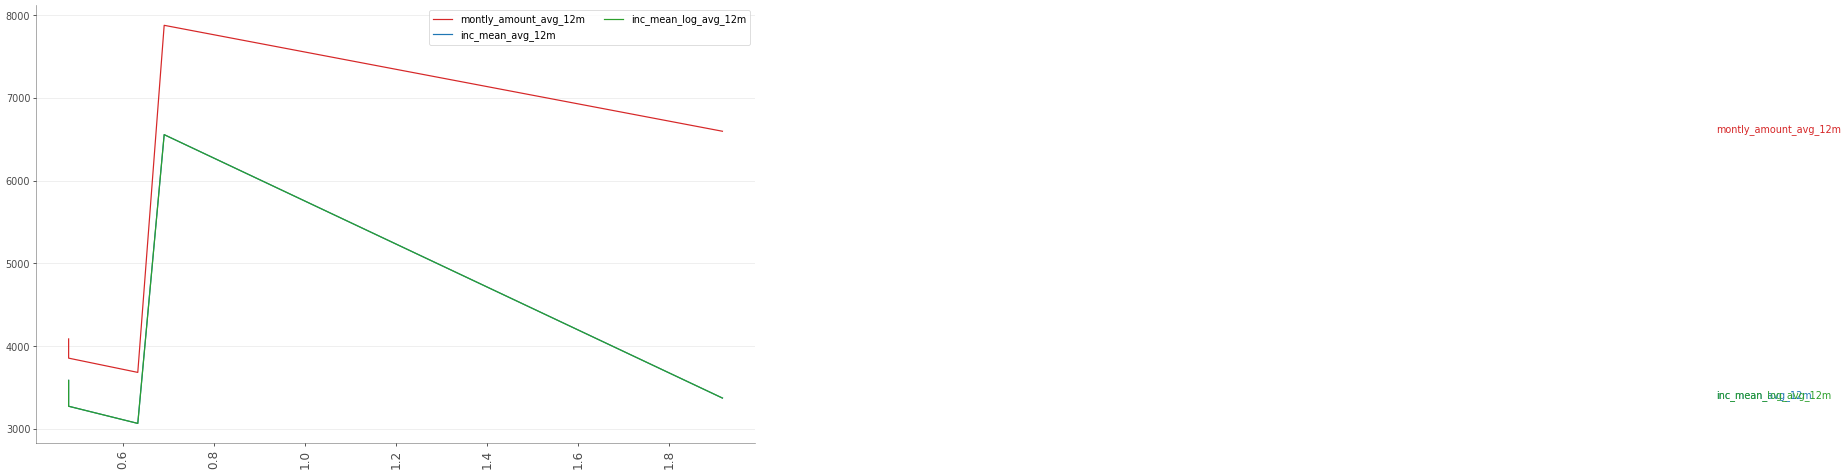

In [16]:
#is outlier 
plot_different_type_series(df_g.toPandas(), 
                           'ratio_sd_mean', 'movs','field', '', '',  dpi_value = 58, width = 16, height = 10, text_ = True)

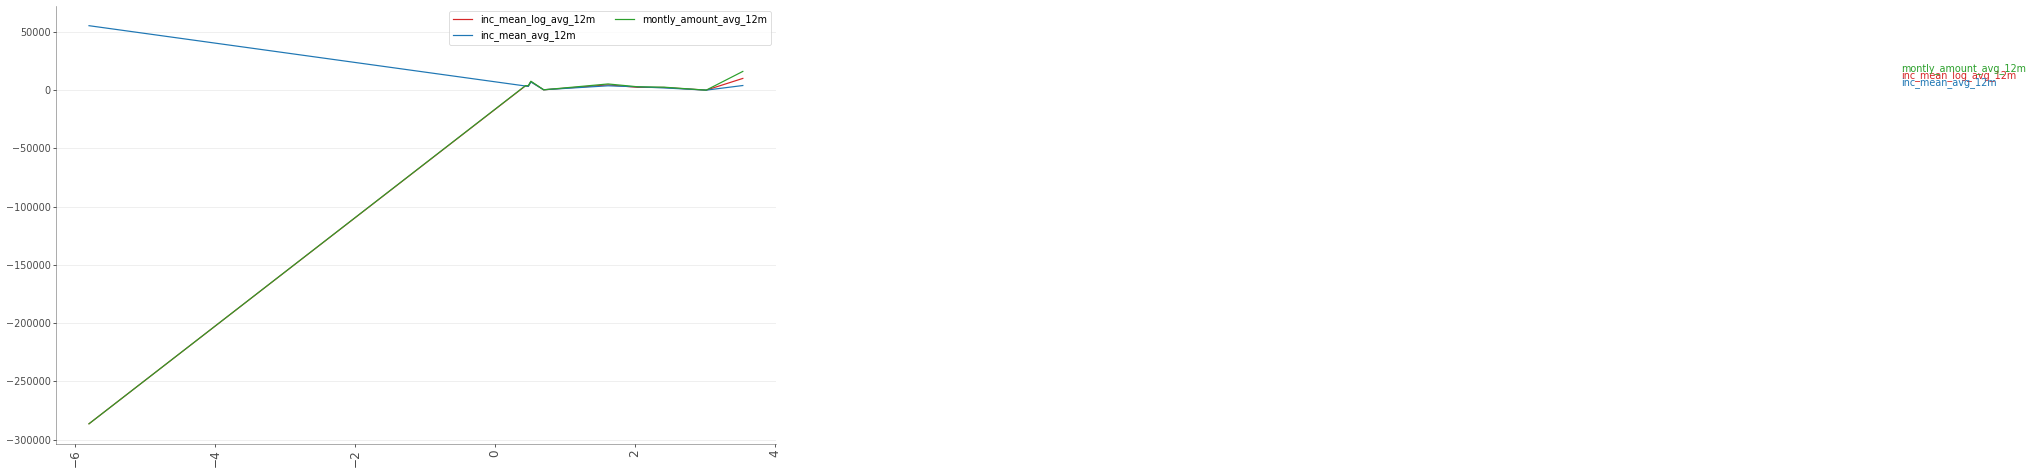

In [16]:
#is outlier 
plot_different_type_series(df_g.toPandas(), 
                           'ratio_sd_mean', 'movs','field', '', '',  dpi_value = 58, width = 16, height = 10, text_ = True)

In [ ]:
#is outlier 
df_g = df_g.withColumn('ratio_sd_mean',sf.when(col('ratio_sd_mean')< 0, (-1)*col('ratio_sd_mean') ).otherwise(col('ratio_sd_mean') ))
plot_different_type_series(df_g.toPandas(), 
                           'ratio_sd_mean', 'movs','field', '', '',  dpi_value = 58, width = 16, height = 10, text_ = True)

In [ ]:
#sustitute 
df_rolling_out = (df_rolling.withColumn('inc_mean', sf.when(col('monthly_partition')== '2021-03-31', col('rolling_avg_3m')).otherwise(col('montly_amount')))
                        .withColumn('inc_median', sf.when(col('monthly_partition')== '2021-03-31', col('rolling_median_3m')).otherwise(col('montly_amount')))
                                    .drop('rolling_avg_3m', 'list', 'rolling_median_3m', 'account_seniority_m', 'account_seniority_y', 'year', 'month'))

df_comparison = rolling_metric_12m(df_rolling_out, partitioned_by = "gf_customer_id", value = "montly_amount", date_field = "monthly_partition")
df_comparison = rolling_metric_12m(df_comparison, partitioned_by = "gf_customer_id", value = "inc_mean", date_field = "monthly_partition")
df_comparison = rolling_metric_12m(df_comparison, partitioned_by = "gf_customer_id", value = "inc_median", date_field = "monthly_partition")



In [ ]:
df_g = (to_explode(df_comparison.select('monthly_partition', 'gf_customer_id', 'montly_amount_avg_12m', 
                                      'inc_mean_avg_12m', 'mean', 'ratio_sd_mean', col('isOutlier').cast('double')), 
                   ['monthly_partition', 'gf_customer_id', 'mean', 'ratio_sd_mean', 'isOutlier'])) #, 'inc_median_avg_12m'
df_g = df_g.filter('''monthly_partition= '2021-03-31' ''') #

In [ ]:
df_g.show()

In [ ]:
#is outlier 
plot_different_type_series(df_g.toPandas(), 
                           'ratio_sd_mean', 'movs','field', '', '',  dpi_value = 58, width = 16, height = 10, text_ = True)